# Q4 BMI Regression Problem

Types of regression

*   **Linear**: predicting a continuous value, i.e. What temperature will it be today?
*   **Logistic**: predicting category of your observation, i.e. Is this a cat or a dog?
*   **Poisson**: predicting a count value, i.e. How many dog will I see in the park?



In [0]:
# import needed libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pylab import fill_between
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

from patsy import dmatrices
import statsmodels.api as sm


In [0]:
def plotTrainingHist(history, epoch, regType):
  plt.figure(figsize=(15,8))
  plt.plot(history.history['val_loss'])
  plt.plot(history.history['loss'])
  plt.xlabel('Epoch')
  plt.legend(['Val_Loss', 'Loss'], loc='upper left')
  plt.title(regType + ': Val Loss:' + str(round(np.mean(history.history['val_loss']),2)) + ' ' + 'Loss:'+ str(round(np.mean(history.history['loss']),2)), fontsize=14)
  plt.show()

def plotTrainingHist2(history, epoch, regType):
  plt.figure(figsize=(15,8))
  plt.plot(history.history['acc'])
  plt.plot(history.history['loss'])
  plt.xlabel('Epoch')
  plt.legend(['Accuracy', 'Loss'], loc='upper left')
  plt.title(regType + ': Accuracy:' + str(round(np.mean(history.history['acc']),2)) + ' ' + 'Loss:'+ str(round(np.mean(history.history['loss']),2)), fontsize=14)
  plt.show()

def plotTrainingHist3(history, epoch, regType):
  plt.figure(figsize=(15,8))
  plt.plot(history.history['acc'])
  plt.plot(history.history['loss'])
  plt.xlabel('Epoch')
  plt.legend(['Accuracy', 'Loss'], loc='upper left')
  plt.title(regType + ': Accuracy:' + str(round(np.mean(history.history['acc']),2)) + ' ' + 'Loss:'+ str(round(np.mean(history.history['loss']),2)), fontsize=14)
  plt.show()

def confMatrix(X_test, y_test, model, regType):
  y_pred1 = model.predict(X_test)
  y_pred = y_pred1.round(0)
  print(classification_report(y_test, y_pred))
  f, ax = plt.subplots(figsize=(13,8))
  model_y_pred1 = model.predict(X_test, verbose=1)
  model_y_pred= model_y_pred1.round(0)
  model_cm = confusion_matrix(y_test,model_y_pred,[0,1])
  sns.heatmap(model_cm, annot=True, fmt='g', cmap="RdBu", xticklabels = ["0", "1"] , yticklabels = ["0", "1"], ax=ax )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title(regType + ' : Confusion Matrix', fontsize=20)

def classReport(X_test, y_test, model):
  y_pred1 = model.predict(X_test)
  y_pred = y_pred1.round(0)
  print(classification_report(y_test, y_pred))

# Styles for Plotting # 
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)


### Exercise 4

Predicting BMI

* erbmi = body mass index (this is what I'm going to try to predict!)
* euexfreq = how many times in the past week the person exercised (outside of their job)
* euwgt = weight, in pounds
* euhgt = height, in inches
* ertpreat = amount of time spent eating and drinking (in minutes) over the past week

Eating & Health Module Dataset [data source](https://www.kaggle.com/bls/eating-health-module-dataset)

In [976]:
import pandas as pd
bmi_data = pd.read_csv('ehresp_2014.csv')
bmi_data.head()

,tucaseid,tulineno,eeincome1,erbmi,erhhch,erincome,erspemch,ertpreat,ertseat,ethgt,etwgt,eudietsoda,eudrink,eueat,euexercise,euexfreq,eufastfd,eufastfdfrq,euffyday,eufdsit,eufinlwgt,eusnap,eugenhth,eugroshp,euhgt,euinclvl,euincome2,eumeat,eumilk,euprpmel,eusoda,eustores,eustreason,eutherm,euwgt,euwic,exincome1
0,20140101140007,1,-2,33.200001,1,-1,-1,30,2,0,0,-1,2,1,2,-1,2,-1,-1,1,5202086.0,1,1,1,60,5,-2,1,2,1,-1,2,1,2,170,1,2
1,20140101140011,1,1,22.700001,3,1,-1,45,14,0,0,-1,2,1,2,-1,1,1,2,1,29400000.0,2,2,3,63,5,-1,1,2,1,-1,1,2,2,128,2,0
2,20140101140028,1,2,49.400002,3,5,-1,60,0,0,0,-1,1,2,2,-1,2,-1,-1,1,26000000.0,2,5,2,62,5,2,-1,-1,2,2,-1,-1,-1,270,2,12
3,20140101140063,1,-2,-1.000000,3,-1,-1,0,0,0,-1,2,1,2,2,-1,2,-1,-1,1,2728880.0,2,2,1,64,5,-2,2,2,1,1,2,6,-1,-2,2,2
4,20140101140168,1,2,31.000000,3,5,-1,65,0,0,0,-1,1,2,1,5,2,-1,-1,1,17500000.0,1,4,1,69,5,2,1,2,1,2,1,1,2,210,1,0


In [977]:
bmi_data.describe()

,tucaseid,tulineno,eeincome1,erbmi,erhhch,erincome,erspemch,ertpreat,ertseat,ethgt,etwgt,eudietsoda,eudrink,eueat,euexercise,euexfreq,eufastfd,eufastfdfrq,euffyday,eufdsit,eufinlwgt,eusnap,eugenhth,eugroshp,euhgt,euinclvl,euincome2,eumeat,eumilk,euprpmel,eusoda,eustores,eustreason,eutherm,euwgt,euwic,exincome1
count,1.121200e+04,11212.0,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,1.121200e+04,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000,11212.000000
mean,2.014066e+13,1.0,1.293525,26.291250,2.885212,2.036479,1.872547,65.678113,16.759900,-0.003122,-0.031127,-0.286657,1.325901,1.432215,1.353104,2.236621,1.407153,1.132804,0.518106,1.059222,8.206391e+06,1.868445,2.477167,1.503032,65.628255,5.176597,-0.231270,0.529344,1.157867,1.464592,0.738494,0.788887,1.366572,0.844006,168.182572,0.512130,4.475027
std,3.456735e+08,0.0,0.845532,8.737788,0.443716,1.694437,2.915099,48.080541,50.643598,0.182376,0.256594,1.204557,0.480756,0.560614,0.548354,3.282512,0.540431,2.485912,1.353144,0.374063,7.321776e+06,0.449477,1.131729,0.704035,9.144713,0.381344,1.452464,0.985731,1.338405,0.691768,1.285256,1.301327,1.872375,1.408404,56.893436,1.481951,17.634628
min,2.014010e+13,1.0,-3.000000,-1.000000,1.000000,-1.000000,-1.000000,0.000000,-3.000000,-1.000000,-1.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-2.000000,-3.000000,-3.000000,7.568438e+05,-3.000000,-3.000000,-3.000000,-3.000000,5.000000,-3.000000,-2.000000,-3.000000,-3.000000,-2.000000,-3.000000,-3.000000,-3.000000,-5.000000,-3.000000,-1.000000
25%,2.014030e+13,1.0,1.000000,23.000000,3.000000,1.000000,-1.000000,30.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,3.497206e+06,2.000000,2.000000,1.000000,63.000000,5.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,140.000000,-1.000000,0.000000
50%,2.014061e+13,1.0,1.000000,26.500000,3.000000,1.000000,1.000000,60.000000,3.000000,0.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,6.005618e+06,2.000000,2.000000,1.000000,66.000000,5.000000,-1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,168.000000,1.000000,0.000000
75%,2.014091e+13,1.0,2.000000,30.400000,3.000000,3.000000,5.000000,90.000000,15.000000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,1.030000e+07,2.000000,3.000000,2.000000,70.000000,5.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,200.000000,2.000000,0.000000
max,2.014121e+13,1.0,3.000000,73.599998,3.000000,5.000000,5.000000,508.000000,990.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,38.000000,2.000000,21.000000,2.000000,3.000000,1.030000e+08,2.000000,5.000000,3.000000,77.000000,6.000000,3.000000,2.000000,2.000000,3.000000,2.000000,5.000000,6.000000,2.000000,340.000000,2.000000,87.000000


In [978]:
columnsRequired = ['erbmi','euexfreq','euwgt','euhgt','ertpreat']
columnstoDrop = ['tucaseid','tulineno','euwgt','euhgt','ertseat','eufinlwgt']
bmi_data2 = bmi_data.copy()
bmi_data2 = bmi_data2.drop(columnstoDrop,axis=1)
bmi_data = bmi_data[columnsRequired]
bmi_data.head(5)

,erbmi,euexfreq,euwgt,euhgt,ertpreat
0,33.200001,-1,170,60,30
1,22.700001,-1,128,63,45
2,49.400002,-1,270,62,60
3,-1.000000,-1,-2,64,0
4,31.000000,5,210,69,65


In [979]:
bmi_data2.head(5)

,eeincome1,erbmi,erhhch,erincome,erspemch,ertpreat,ethgt,etwgt,eudietsoda,eudrink,eueat,euexercise,euexfreq,eufastfd,eufastfdfrq,euffyday,eufdsit,eusnap,eugenhth,eugroshp,euinclvl,euincome2,eumeat,eumilk,euprpmel,eusoda,eustores,eustreason,eutherm,euwic,exincome1
0,-2,33.200001,1,-1,-1,30,0,0,-1,2,1,2,-1,2,-1,-1,1,1,1,1,5,-2,1,2,1,-1,2,1,2,1,2
1,1,22.700001,3,1,-1,45,0,0,-1,2,1,2,-1,1,1,2,1,2,2,3,5,-1,1,2,1,-1,1,2,2,2,0
2,2,49.400002,3,5,-1,60,0,0,-1,1,2,2,-1,2,-1,-1,1,2,5,2,5,2,-1,-1,2,2,-1,-1,-1,2,12
3,-2,-1.000000,3,-1,-1,0,0,-1,2,1,2,2,-1,2,-1,-1,1,2,2,1,5,-2,2,2,1,1,2,6,-1,2,2
4,2,31.000000,3,5,-1,65,0,0,-1,1,2,1,5,2,-1,-1,1,1,4,1,5,2,1,2,1,2,1,1,2,1,0


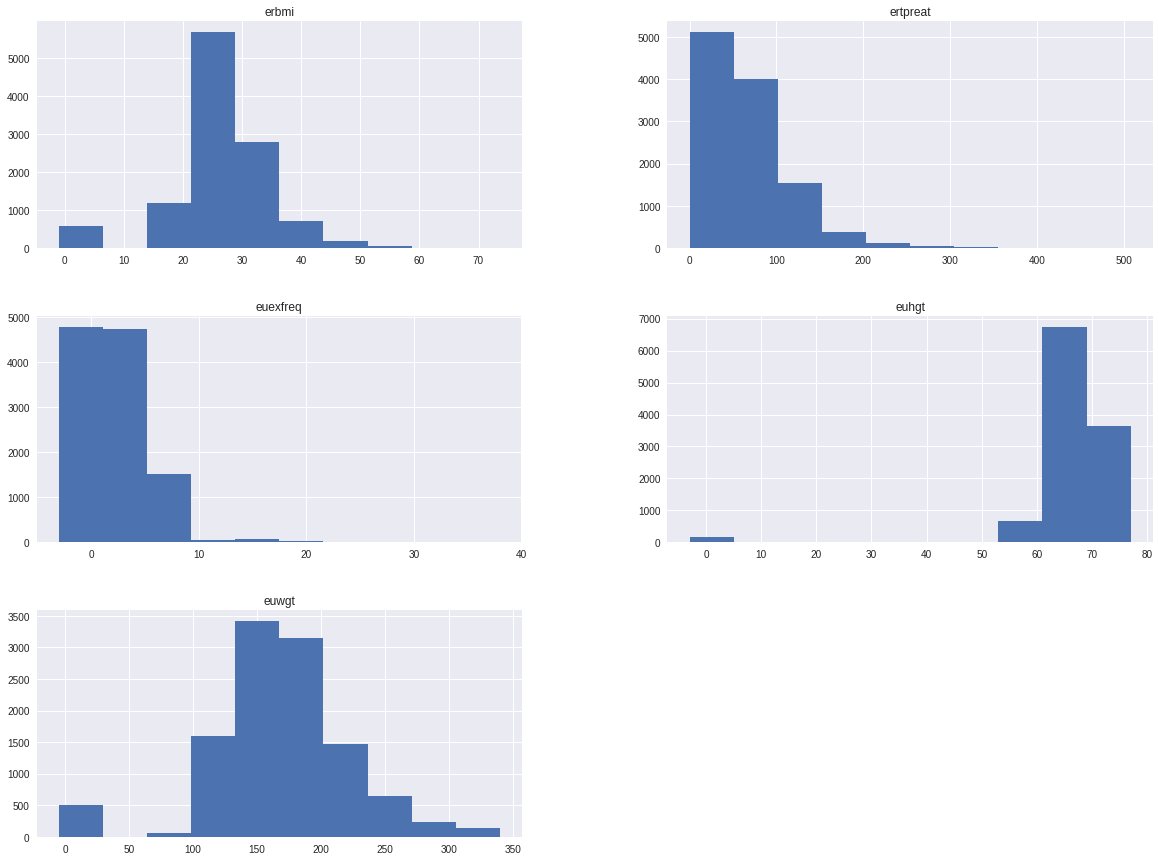

In [980]:
bmi_data.hist(bins=10, figsize=(20,15))
plt.show()

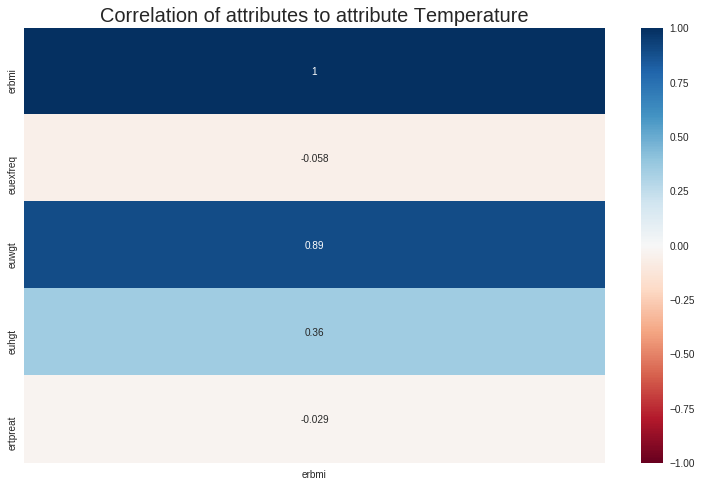

In [981]:
f, ax = plt.subplots(figsize=(13,8))
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

ax = sns.heatmap(bmi_data.corr()[['erbmi']], annot=True, vmin=-1, vmax=1, cmap="RdBu", ax=ax)
ax.set_title('Correlation of attributes to attribute Temperature', fontsize=20);

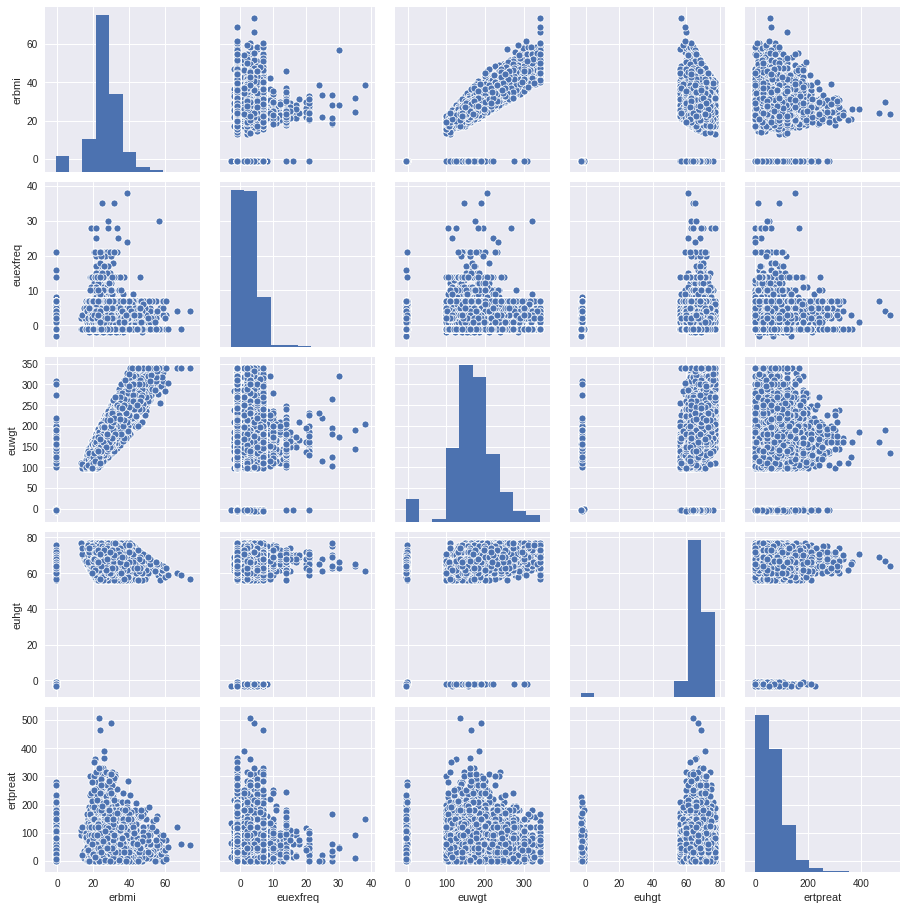

In [982]:
sns.pairplot(bmi_data)

In [983]:
# There are some records with negative emi, can be removed
print(len(bmi_data))
bmi_data = bmi_data[bmi_data['erbmi']>0]
bmi_data2 = bmi_data2[bmi_data2['erbmi']>0]
print(len(bmi_data))

11212
10637


In [984]:
bmi_data.describe()

,erbmi,euexfreq,euwgt,euhgt,ertpreat
count,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000
mean,27.766522,2.269907,176.277146,66.689292,65.851744
std,6.167176,3.291757,44.267974,4.131012,48.088072
min,13.000000,-2.000000,98.000000,56.000000,0.000000
25%,23.600000,-1.000000,145.000000,64.000000,30.000000
50%,26.600000,2.000000,170.000000,66.000000,60.000000
75%,30.700001,4.000000,200.000000,70.000000,90.000000
max,73.599998,38.000000,340.000000,77.000000,508.000000


In [985]:
bmi_data2.describe()

,eeincome1,erbmi,erhhch,erincome,erspemch,ertpreat,ethgt,etwgt,eudietsoda,eudrink,eueat,euexercise,euexfreq,eufastfd,eufastfdfrq,euffyday,eufdsit,eusnap,eugenhth,eugroshp,euinclvl,euincome2,eumeat,eumilk,euprpmel,eusoda,eustores,eustreason,eutherm,euwic,exincome1
count,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000
mean,1.309486,27.766522,2.885964,2.041365,1.873461,65.851744,0.011657,0.014196,-0.291624,1.323399,1.431983,1.366457,2.269907,1.408856,1.158221,0.534173,1.068628,1.884272,2.494782,1.509636,5.176460,-0.217919,0.520353,1.146564,1.477860,0.749553,0.778697,1.359970,0.836326,0.511422,4.039861
std,0.806329,6.167176,0.441658,1.679181,2.915181,48.088072,0.139357,0.152347,1.200139,0.478133,0.554482,0.488833,3.291757,0.517364,2.498302,1.350791,0.317163,0.376608,1.090100,0.705394,0.381229,1.431948,0.988693,1.343591,0.672629,1.284282,1.299863,1.874511,1.409420,1.480342,16.766439
min,-3.000000,13.000000,1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,-3.000000,-3.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-3.000000,-2.000000,-3.000000,-3.000000,5.000000,-3.000000,-2.000000,-3.000000,-2.000000,-2.000000,-2.000000,-3.000000,-2.000000,-2.000000,0.000000
25%,1.000000,23.600000,3.000000,1.000000,-1.000000,30.000000,0.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,2.000000,2.000000,1.000000,5.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,1.000000,26.600000,3.000000,1.000000,1.000000,60.000000,0.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,5.000000,-1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
75%,2.000000,30.700001,3.000000,3.000000,5.000000,90.000000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,2.000000,5.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,0.000000
max,3.000000,73.599998,3.000000,5.000000,5.000000,508.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,38.000000,2.000000,21.000000,2.000000,3.000000,2.000000,5.000000,3.000000,6.000000,3.000000,2.000000,2.000000,3.000000,2.000000,5.000000,6.000000,2.000000,2.000000,87.000000


In [987]:
bmi_data.describe()

,erbmi,euexfreq,euwgt,euhgt,ertpreat
count,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000
mean,27.766522,2.269907,176.277146,66.689292,65.851744
std,6.167176,3.291757,44.267974,4.131012,48.088072
min,13.000000,-2.000000,98.000000,56.000000,0.000000
25%,23.600000,-1.000000,145.000000,64.000000,30.000000
50%,26.600000,2.000000,170.000000,66.000000,60.000000
75%,30.700001,4.000000,200.000000,70.000000,90.000000
max,73.599998,38.000000,340.000000,77.000000,508.000000


In [988]:
bmi_data2.describe()

,eeincome1,erbmi,erhhch,erincome,erspemch,ertpreat,ethgt,etwgt,eudietsoda,eudrink,eueat,euexercise,euexfreq,eufastfd,eufastfdfrq,euffyday,eufdsit,eusnap,eugenhth,eugroshp,euinclvl,euincome2,eumeat,eumilk,euprpmel,eusoda,eustores,eustreason,eutherm,euwic,exincome1
count,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000
mean,1.309486,27.766522,2.885964,2.041365,1.873461,65.851744,0.011657,0.014196,-0.291624,1.323399,1.431983,1.366457,2.269907,1.408856,1.158221,0.534173,1.068628,1.884272,2.494782,1.509636,5.176460,-0.217919,0.520353,1.146564,1.477860,0.749553,0.778697,1.359970,0.836326,0.511422,4.039861
std,0.806329,6.167176,0.441658,1.679181,2.915181,48.088072,0.139357,0.152347,1.200139,0.478133,0.554482,0.488833,3.291757,0.517364,2.498302,1.350791,0.317163,0.376608,1.090100,0.705394,0.381229,1.431948,0.988693,1.343591,0.672629,1.284282,1.299863,1.874511,1.409420,1.480342,16.766439
min,-3.000000,13.000000,1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,-3.000000,-3.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-3.000000,-2.000000,-3.000000,-3.000000,5.000000,-3.000000,-2.000000,-3.000000,-2.000000,-2.000000,-2.000000,-3.000000,-2.000000,-2.000000,0.000000
25%,1.000000,23.600000,3.000000,1.000000,-1.000000,30.000000,0.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,2.000000,2.000000,1.000000,5.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,1.000000,26.600000,3.000000,1.000000,1.000000,60.000000,0.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,5.000000,-1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
75%,2.000000,30.700001,3.000000,3.000000,5.000000,90.000000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,2.000000,5.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,0.000000
max,3.000000,73.599998,3.000000,5.000000,5.000000,508.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,38.000000,2.000000,21.000000,2.000000,3.000000,2.000000,5.000000,3.000000,6.000000,3.000000,2.000000,2.000000,3.000000,2.000000,5.000000,6.000000,2.000000,2.000000,87.000000


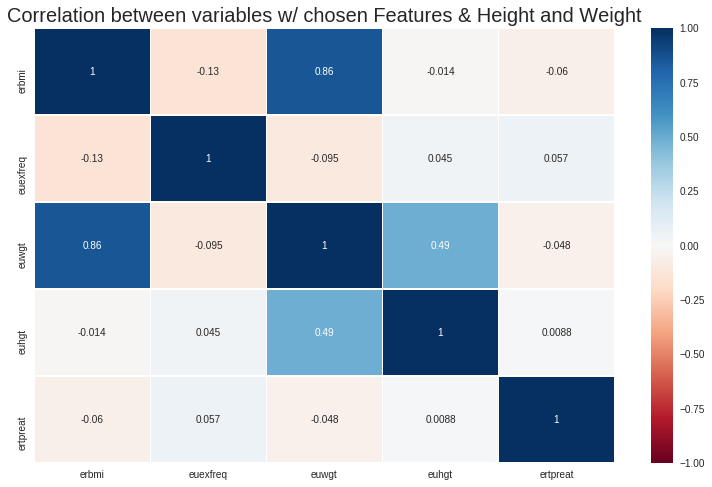

In [989]:
f, ax = plt.subplots(figsize=(13,8))
ax = sns.heatmap(bmi_data.corr(),cmap="RdBu", annot=True, xticklabels=True, yticklabels=True, linewidths=.5, vmin=-1, vmax=1, ax=ax)
ax.set_title('Correlation between variables w/ chosen Features & Height and Weight', fontsize=20);

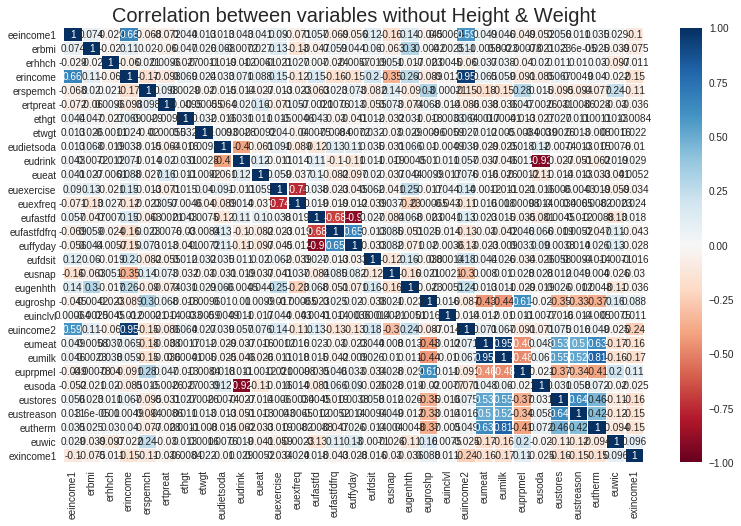

In [990]:
f, ax = plt.subplots(figsize=(13,8))
ax = sns.heatmap(bmi_data2.corr(),cmap="RdBu", annot=True, xticklabels=True, yticklabels=True, linewidths=.5, vmin=-1, vmax=1, ax=ax)
ax.set_title('Correlation between variables without Height & Weight', fontsize=20);

###Linear BMI Prediction with Weight & Height

In [0]:
columnsRequired = ['euexfreq','euwgt','euhgt','ertpreat']

X = bmi_data[columnsRequired].values
y = bmi_data['erbmi'].values

###### Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression

ls = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,random_state=0)
ls.fit(X_train, y_train)
y_pred = ls.predict(X_test)

In [993]:
d1_linear = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
d1_linear

,Actual,Predicted
0,24.000000,25.027032
1,26.500000,26.271414
2,23.900000,24.370599
3,30.200001,30.030459
4,26.600000,26.748507
...,...,...
3506,23.900000,23.864704
3507,28.100000,27.971613
3508,30.500000,30.952391
3509,33.200001,32.473549


In [994]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.49367312100980315
Mean Squared Error: 0.6200294042815054
Root Mean Squared Error: 0.7874194589172314


<Figure size 432x288 with 0 Axes>

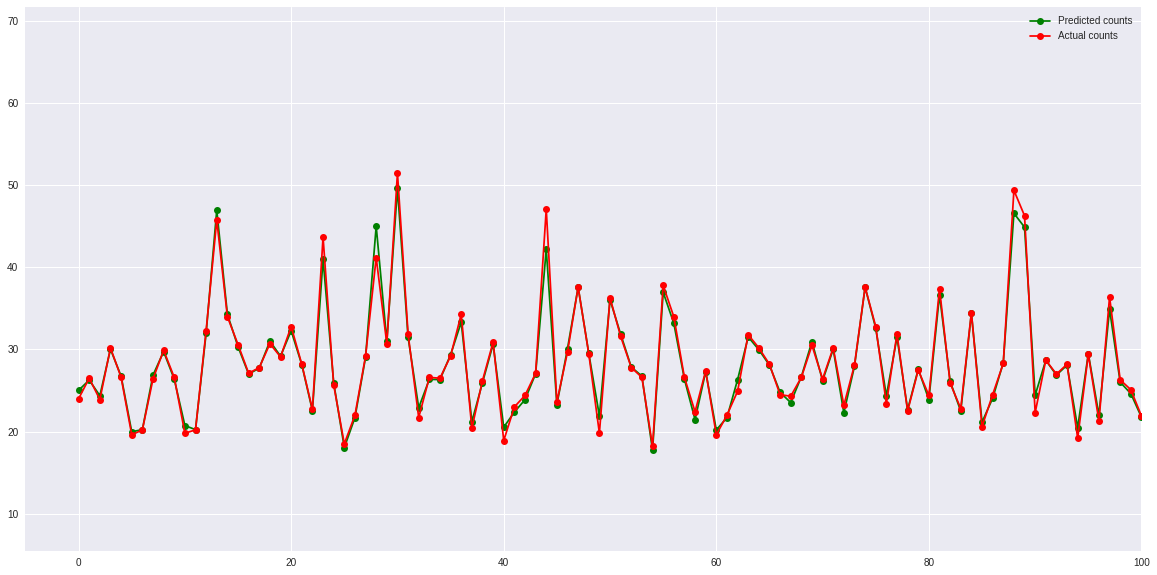

In [995]:
fig = plt.figure()
fig.suptitle('Predicted vs Actual BMI')

plt.figure(figsize=(20,10))
plt.xlim(-5,100)
predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'go-', label='Predicted counts')
actual, = plt.plot(pd.DataFrame(y_test.flatten()), 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
 
plt.show()

##### Linear Regression with Keras

In [0]:
from keras import backend as K

def rmspe(y_true, y_pred):
        return K.sqrt(K.mean(K.square((y_pred - y_true)/y_true),axis=-1)) 

In [997]:
X_train, X_test , y_train , y_test = train_test_split(X, y, test_size=0.30, random_state=0)
lr_model = Sequential()
lr_model.add(Dense(1,input_shape=(X.shape[1],),activation='relu'))
lr_model.compile(Adam(lr=0.01),'mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss',patience=8,verbose=1)
lr_history = lr_model.fit(X_train,y_train, verbose=2, epochs=100, validation_data=(X_test,y_test), batch_size=700)

Train on 7445 samples, validate on 3192 samples
Epoch 1/100
 - 3s - loss: 799.7913 - val_loss: 793.4706
Epoch 2/100
 - 0s - loss: 749.9172 - val_loss: 662.9660
Epoch 3/100
 - 0s - loss: 553.6470 - val_loss: 383.5852
Epoch 4/100
 - 0s - loss: 283.1623 - val_loss: 162.7991
Epoch 5/100
 - 0s - loss: 105.5463 - val_loss: 52.2995
Epoch 6/100
 - 0s - loss: 32.6989 - val_loss: 18.3312
Epoch 7/100
 - 0s - loss: 15.0946 - val_loss: 13.9047
Epoch 8/100
 - 0s - loss: 13.7627 - val_loss: 14.0378
Epoch 9/100
 - 0s - loss: 13.7088 - val_loss: 13.4136
Epoch 10/100
 - 0s - loss: 12.9909 - val_loss: 12.8560
Epoch 11/100
 - 0s - loss: 12.5072 - val_loss: 12.5419
Epoch 12/100
 - 0s - loss: 12.2713 - val_loss: 12.3769
Epoch 13/100
 - 0s - loss: 12.1385 - val_loss: 12.2737
Epoch 14/100
 - 0s - loss: 12.0378 - val_loss: 12.1345
Epoch 15/100
 - 0s - loss: 11.9498 - val_loss: 12.0576
Epoch 16/100
 - 0s - loss: 11.8968 - val_loss: 12.0012
Epoch 17/100
 - 0s - loss: 11.8561 - val_loss: 11.9584
Epoch 18/100
 - 0

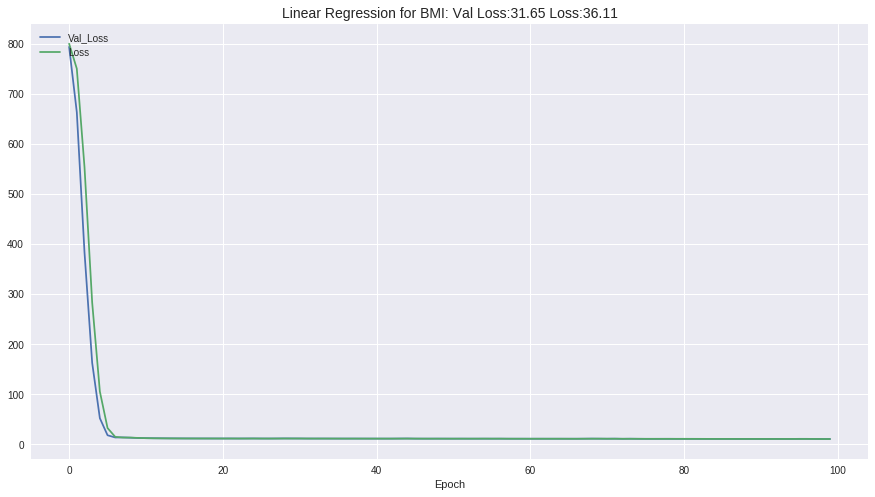

In [998]:
plotTrainingHist(lr_history, 30, 'Linear Regression for BMI')

In [0]:
y_pred = lr_model.predict(X_test)

<Figure size 432x288 with 0 Axes>

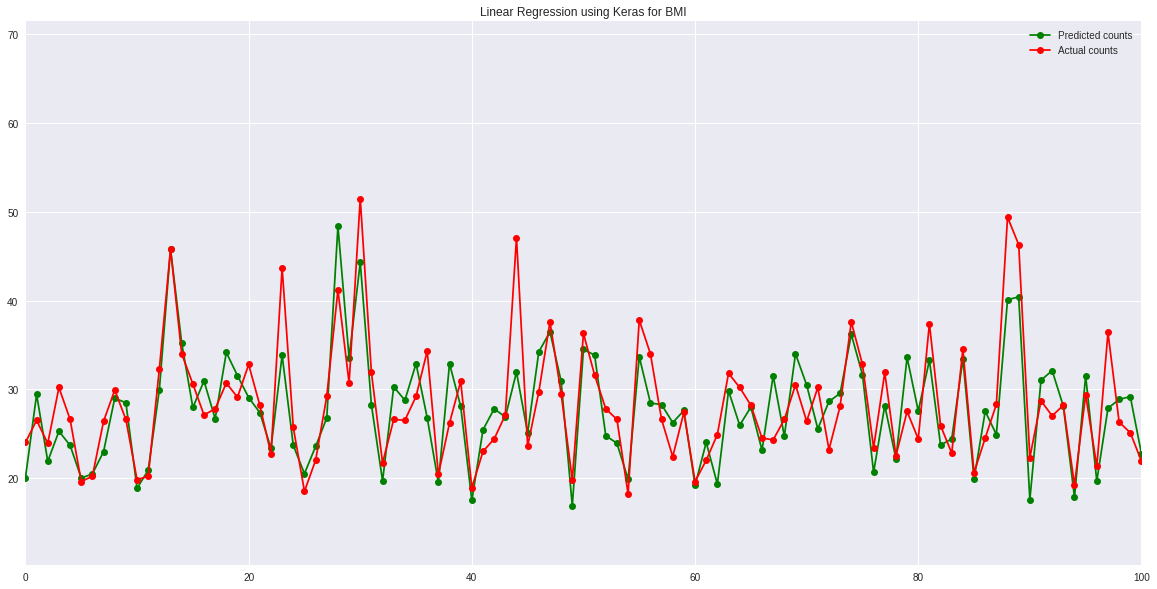

In [1000]:
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.xlim(0,100)
plt.title('Linear Regression using Keras for BMI')
predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'go-', label='Predicted counts')
actual, = plt.plot(pd.DataFrame(y_test.flatten()), 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
 
plt.show()

##### Neural Network

In [0]:
X_train, X_test , y_train , y_test = train_test_split(X, y, test_size=0.30, random_state=1)
dnn_model = Sequential()
dnn_model.add(Dense(32,input_shape=(X.shape[1],),activation='relu'))
dnn_model.add(Dense(16,activation='relu'))
dnn_model.add(Dense(4,activation='relu'))
dnn_model.add(Dense(4))
dnn_model.compile(Adam(lr=0.08),'mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss',patience=8,verbose=1)
dn_history = dnn_model.fit(X_train,y_train, verbose=2, epochs=100, validation_data=(X_test,y_test), batch_size=70,callbacks=[early_stop])

In [0]:
plotTrainingHist(dn_history, 30, 'Neural Network Regression for BMI')

In [0]:
y_pred = dnn_model.predict(X_test)

In [0]:
fig = plt.figure()
fig.suptitle('Predicted vs Actual BMI')

plt.figure(figsize=(20,10))
plt.title('Neural Network: Predicted vs Actual Temperature & Humidity')
plt.xlim(0,100)
predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'go-', label='Predicted counts')
actual, = plt.plot(pd.DataFrame(y_test.flatten()), 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
 
plt.show()

###Linear BMI Prediction without Weight & Height

In [1001]:
bmi_data2

,eeincome1,erbmi,erhhch,erincome,erspemch,ertpreat,ethgt,etwgt,eudietsoda,eudrink,eueat,euexercise,euexfreq,eufastfd,eufastfdfrq,euffyday,eufdsit,eusnap,eugenhth,eugroshp,euinclvl,euincome2,eumeat,eumilk,euprpmel,eusoda,eustores,eustreason,eutherm,euwic,exincome1
0,-2,33.200001,1,-1,-1,30,0,0,-1,2,1,2,-1,2,-1,-1,1,1,1,1,5,-2,1,2,1,-1,2,1,2,1,2
1,1,22.700001,3,1,-1,45,0,0,-1,2,1,2,-1,1,1,2,1,2,2,3,5,-1,1,2,1,-1,1,2,2,2,0
2,2,49.400002,3,5,-1,60,0,0,-1,1,2,2,-1,2,-1,-1,1,2,5,2,5,2,-1,-1,2,2,-1,-1,-1,2,12
4,2,31.000000,3,5,-1,65,0,0,-1,1,2,1,5,2,-1,-1,1,1,4,1,5,2,1,2,1,2,1,1,2,1,0
5,1,30.700001,3,1,1,20,0,0,1,1,1,1,2,1,3,1,1,2,3,2,5,-1,-1,-1,2,1,-1,-1,-1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11207,1,27.400000,3,1,-1,45,0,0,2,1,2,1,2,1,3,2,1,2,2,1,6,-1,1,2,1,1,1,2,2,-1,0
11208,2,24.000000,3,5,5,30,0,0,-1,1,2,2,-1,1,-2,2,2,2,3,3,6,2,1,2,3,2,1,2,2,2,0
11209,1,22.200001,3,1,5,90,0,0,-1,2,1,1,2,1,4,2,1,2,1,1,6,-1,1,2,1,-1,3,3,2,-1,0
11210,2,23.400000,3,5,-1,240,0,0,1,1,2,1,1,1,3,1,1,2,1,2,6,2,-1,-1,2,1,-1,-1,-1,2,0


In [1002]:
bmi_data2.count(0)/bmi_data2.shape[0] * 100

eeincome1      100.0
erbmi          100.0
erhhch         100.0
erincome       100.0
erspemch       100.0
ertpreat       100.0
ethgt          100.0
etwgt          100.0
eudietsoda     100.0
eudrink        100.0
eueat          100.0
euexercise     100.0
euexfreq       100.0
eufastfd       100.0
eufastfdfrq    100.0
euffyday       100.0
eufdsit        100.0
eusnap         100.0
eugenhth       100.0
eugroshp       100.0
euinclvl       100.0
euincome2      100.0
eumeat         100.0
eumilk         100.0
euprpmel       100.0
eusoda         100.0
eustores       100.0
eustreason     100.0
eutherm        100.0
euwic          100.0
exincome1      100.0
dtype: float64

In [1003]:
bmi_data2.describe()

,eeincome1,erbmi,erhhch,erincome,erspemch,ertpreat,ethgt,etwgt,eudietsoda,eudrink,eueat,euexercise,euexfreq,eufastfd,eufastfdfrq,euffyday,eufdsit,eusnap,eugenhth,eugroshp,euinclvl,euincome2,eumeat,eumilk,euprpmel,eusoda,eustores,eustreason,eutherm,euwic,exincome1
count,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000
mean,1.309486,27.766522,2.885964,2.041365,1.873461,65.851744,0.011657,0.014196,-0.291624,1.323399,1.431983,1.366457,2.269907,1.408856,1.158221,0.534173,1.068628,1.884272,2.494782,1.509636,5.176460,-0.217919,0.520353,1.146564,1.477860,0.749553,0.778697,1.359970,0.836326,0.511422,4.039861
std,0.806329,6.167176,0.441658,1.679181,2.915181,48.088072,0.139357,0.152347,1.200139,0.478133,0.554482,0.488833,3.291757,0.517364,2.498302,1.350791,0.317163,0.376608,1.090100,0.705394,0.381229,1.431948,0.988693,1.343591,0.672629,1.284282,1.299863,1.874511,1.409420,1.480342,16.766439
min,-3.000000,13.000000,1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,-3.000000,-3.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-3.000000,-2.000000,-3.000000,-3.000000,5.000000,-3.000000,-2.000000,-3.000000,-2.000000,-2.000000,-2.000000,-3.000000,-2.000000,-2.000000,0.000000
25%,1.000000,23.600000,3.000000,1.000000,-1.000000,30.000000,0.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,2.000000,2.000000,1.000000,5.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,1.000000,26.600000,3.000000,1.000000,1.000000,60.000000,0.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,5.000000,-1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
75%,2.000000,30.700001,3.000000,3.000000,5.000000,90.000000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,2.000000,5.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,0.000000
max,3.000000,73.599998,3.000000,5.000000,5.000000,508.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,38.000000,2.000000,21.000000,2.000000,3.000000,2.000000,5.000000,3.000000,6.000000,3.000000,2.000000,2.000000,3.000000,2.000000,5.000000,6.000000,2.000000,2.000000,87.000000


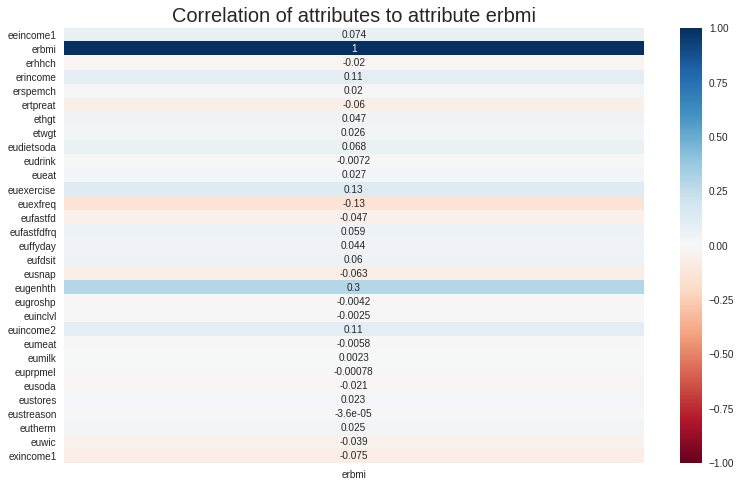

In [1004]:
f, ax = plt.subplots(figsize=(13,8))
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

ax = sns.heatmap(bmi_data2.corr()[['erbmi']], annot=True, vmin=-1, vmax=1, cmap="RdBu", ax=ax)
ax.set_title('Correlation of attributes to attribute erbmi', fontsize=20);

In [1005]:
(bmi_data2.corr()[['erbmi']].abs()).sort_values(by='erbmi', ascending=False)

,erbmi
erbmi,1.000000
eugenhth,0.296464
euexfreq,0.133380
euexercise,0.128410
euincome2,0.106526
erincome,0.105426
exincome1,0.075428
eeincome1,0.074220
eudietsoda,0.067709
eusnap,0.063280


In [0]:
def init_check(df):
    columns = df.columns    
    lst = []
    for feature in columns : 
        dtype = df[feature].dtypes
        num_null = df[feature].isnull().sum()
        num_unique = df[feature].nunique()
        lst.append([feature, dtype, num_null, num_unique])
    
    check_df = pd.DataFrame(lst)
    check_df.columns = ['feature','dtype','num_null','num_unique']
    check_df = check_df.sort_values(by='dtype', axis=0, ascending=True)
    
    return check_df

In [1007]:
init_check(df=bmi_data2)

,feature,dtype,num_null,num_unique
0,eeincome1,int64,0,5
28,eutherm,int64,0,4
27,eustreason,int64,0,9
26,eustores,int64,0,7
25,eusoda,int64,0,4
24,euprpmel,int64,0,4
23,eumilk,int64,0,5
22,eumeat,int64,0,4
21,euincome2,int64,0,6
20,euinclvl,int64,0,2


In [0]:
def categorical_encoding(df, categorical_cloumns, encoding_method):    
    if encoding_method == 'label':
        encoder = LabelEncoder()
        encoded = df[categorical_cloumns].apply(encoder.fit_transform)
        return encoded
    
    elif encoding_method == 'one-hot':
        encoded = pd.DataFrame()
        for feature in categorical_cloumns:
            dummies = pd.get_dummies(df[feature], prefix=feature)
            encoded = pd.concat([encoded, dummies], axis=1)
        return encoded

In [0]:
categorical_columns = bmi_data2.select_dtypes(include=['float64']).columns

In [0]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [0]:
encoded=categorical_encoding(df=bmi_data2,categorical_cloumns=categorical_columns, encoding_method='label')

In [1012]:
bmi_data2= bmi_data2.drop(columns=categorical_columns, axis=1)
bmi_data2= pd.concat([bmi_data2, encoded], axis=1)
bmi_data2.head()

,eeincome1,erhhch,erincome,erspemch,ertpreat,ethgt,etwgt,eudietsoda,eudrink,eueat,euexercise,euexfreq,eufastfd,eufastfdfrq,euffyday,eufdsit,eusnap,eugenhth,eugroshp,euinclvl,euincome2,eumeat,eumilk,euprpmel,eusoda,eustores,eustreason,eutherm,euwic,exincome1,erbmi
0,-2,1,-1,-1,30,0,0,-1,2,1,2,-1,2,-1,-1,1,1,1,1,5,-2,1,2,1,-1,2,1,2,1,2,181
1,1,3,1,-1,45,0,0,-1,2,1,2,-1,1,1,2,1,2,2,3,5,-1,1,2,1,-1,1,2,2,2,0,76
2,2,3,5,-1,60,0,0,-1,1,2,2,-1,2,-1,-1,1,2,5,2,5,2,-1,-1,2,2,-1,-1,-1,2,12,330
4,2,3,5,-1,65,0,0,-1,1,2,1,5,2,-1,-1,1,1,4,1,5,2,1,2,1,2,1,1,2,1,0,159
5,1,3,1,1,20,0,0,1,1,1,1,2,1,3,1,1,2,3,2,5,-1,-1,-1,2,1,-1,-1,-1,2,0,156


In [1013]:
bmi_data2.describe()

,eeincome1,erhhch,erincome,erspemch,ertpreat,ethgt,etwgt,eudietsoda,eudrink,eueat,euexercise,euexfreq,eufastfd,eufastfdfrq,euffyday,eufdsit,eusnap,eugenhth,eugroshp,euinclvl,euincome2,eumeat,eumilk,euprpmel,eusoda,eustores,eustreason,eutherm,euwic,exincome1,erbmi
count,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000,10637.000000
mean,1.309486,2.885964,2.041365,1.873461,65.851744,0.011657,0.014196,-0.291624,1.323399,1.431983,1.366457,2.269907,1.408856,1.158221,0.534173,1.068628,1.884272,2.494782,1.509636,5.176460,-0.217919,0.520353,1.146564,1.477860,0.749553,0.778697,1.359970,0.836326,0.511422,4.039861,126.255335
std,0.806329,0.441658,1.679181,2.915181,48.088072,0.139357,0.152347,1.200139,0.478133,0.554482,0.488833,3.291757,0.517364,2.498302,1.350791,0.317163,0.376608,1.090100,0.705394,0.381229,1.431948,0.988693,1.343591,0.672629,1.284282,1.299863,1.874511,1.409420,1.480342,16.766439,59.956093
min,-3.000000,1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,-3.000000,-3.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-3.000000,-2.000000,-3.000000,-3.000000,5.000000,-3.000000,-2.000000,-3.000000,-2.000000,-2.000000,-2.000000,-3.000000,-2.000000,-2.000000,0.000000,0.000000
25%,1.000000,3.000000,1.000000,-1.000000,30.000000,0.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,2.000000,2.000000,1.000000,5.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,85.000000
50%,1.000000,3.000000,1.000000,1.000000,60.000000,0.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,5.000000,-1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,115.000000
75%,2.000000,3.000000,3.000000,5.000000,90.000000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,2.000000,5.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,0.000000,156.000000
max,3.000000,3.000000,5.000000,5.000000,508.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,38.000000,2.000000,21.000000,2.000000,3.000000,2.000000,5.000000,3.000000,6.000000,3.000000,2.000000,2.000000,3.000000,2.000000,5.000000,6.000000,2.000000,2.000000,87.000000,373.000000


#### Linear Regression

In [0]:
X_1 = bmi_data2.drop('erbmi', axis=1).values
y_1 = bmi_data2['erbmi'].values

In [0]:
from sklearn.linear_model import LinearRegression

ls = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size = 0.30,random_state=0)
ls.fit(X_train, y_train)
y_pred = ls.predict(X_test)

In [1016]:
d1_linear = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
d1_linear

,Actual,Predicted
0,89,122.230027
1,114,115.197667
2,88,114.553032
3,151,139.016586
4,115,118.980366
...,...,...
3187,91,121.222320
3188,65,135.985690
3189,120,121.357720
3190,64,124.570451


<Figure size 432x288 with 0 Axes>

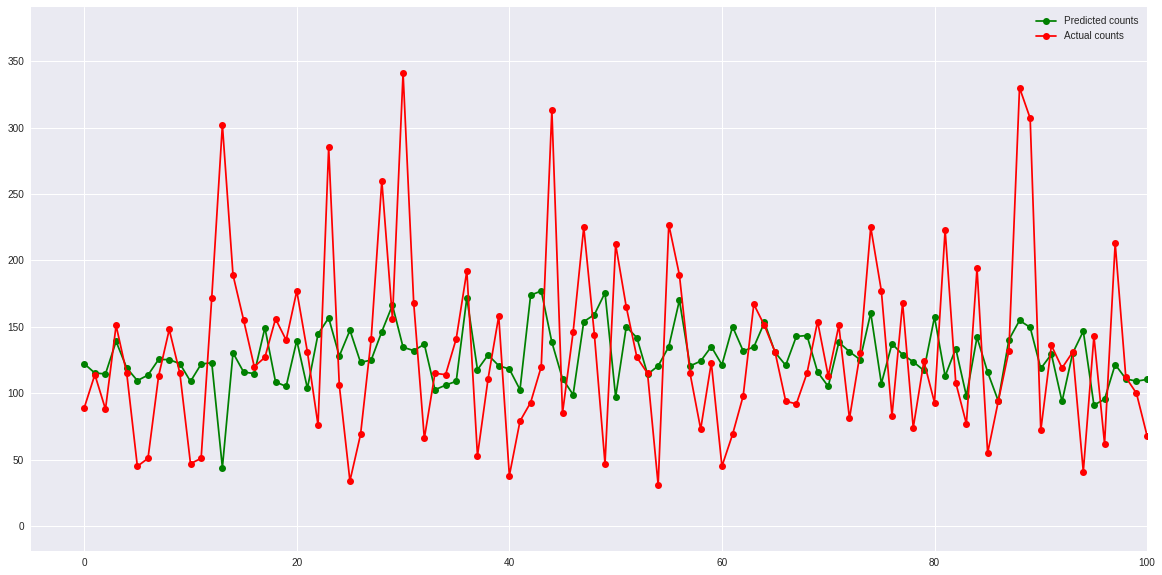

In [1018]:
fig = plt.figure()
fig.suptitle('Predicted vs Actual BMI')

plt.figure(figsize=(20,10))
plt.xlim(-5,100)
predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'go-', label='Predicted counts')
actual, = plt.plot(pd.DataFrame(y_test.flatten()), 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
 
plt.show()

In [1017]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 43.06062380495522
Mean Squared Error: 3259.9880810182985
Root Mean Squared Error: 57.09630531845558


##### Keras Linear Regression

In [0]:
from keras import backend as K

def rmspe(y_true, y_pred):
        return K.sqrt(K.mean(K.square((y_pred - y_true)/y_true),axis=-1)) 

In [1036]:
X_train, X_test , y_train , y_test = train_test_split(X_1, y_1, test_size=0.30, random_state=0)
lr_model = Sequential()
lr_model.add(Dense(1,input_shape=(X_1.shape[1],),activation='relu'))
lr_model.compile(Adam(lr=0.5),'mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss',patience=8,verbose=1)
lr_history = lr_model.fit(X_train,y_train, verbose=2, epochs=30, validation_data=(X_test,y_test), batch_size=1000,callbacks=[early_stop])

Train on 7445 samples, validate on 3192 samples
Epoch 1/30
 - 3s - loss: 10120.6182 - val_loss: 5811.4055
Epoch 2/30
 - 0s - loss: 4877.4576 - val_loss: 3807.3178
Epoch 3/30
 - 0s - loss: 3866.3141 - val_loss: 3670.3917
Epoch 4/30
 - 0s - loss: 3599.4292 - val_loss: 3492.6280
Epoch 5/30
 - 0s - loss: 3366.8571 - val_loss: 3454.2288
Epoch 6/30
 - 0s - loss: 3323.3756 - val_loss: 3369.1464
Epoch 7/30
 - 0s - loss: 3271.7364 - val_loss: 3333.1249
Epoch 8/30
 - 0s - loss: 3247.0167 - val_loss: 3336.4510
Epoch 9/30
 - 0s - loss: 3238.1701 - val_loss: 3320.0771
Epoch 10/30
 - 0s - loss: 3224.9293 - val_loss: 3312.8407
Epoch 11/30
 - 0s - loss: 3218.9555 - val_loss: 3314.4232
Epoch 12/30
 - 0s - loss: 3218.2396 - val_loss: 3299.0535
Epoch 13/30
 - 0s - loss: 3211.9311 - val_loss: 3302.4056
Epoch 14/30
 - 0s - loss: 3207.8364 - val_loss: 3290.3722
Epoch 15/30
 - 0s - loss: 3194.4613 - val_loss: 3289.3809
Epoch 16/30
 - 0s - loss: 3192.0552 - val_loss: 3285.5281
Epoch 17/30
 - 0s - loss: 3188.3

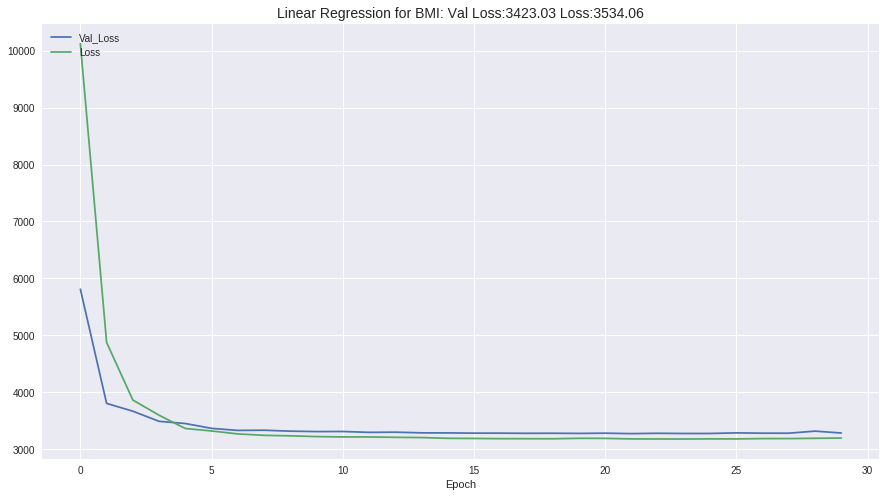

In [1037]:
plotTrainingHist(lr_history, 30, 'Linear Regression for BMI')

In [0]:
y_pred = lr_model.predict(X_test)

<Figure size 432x288 with 0 Axes>

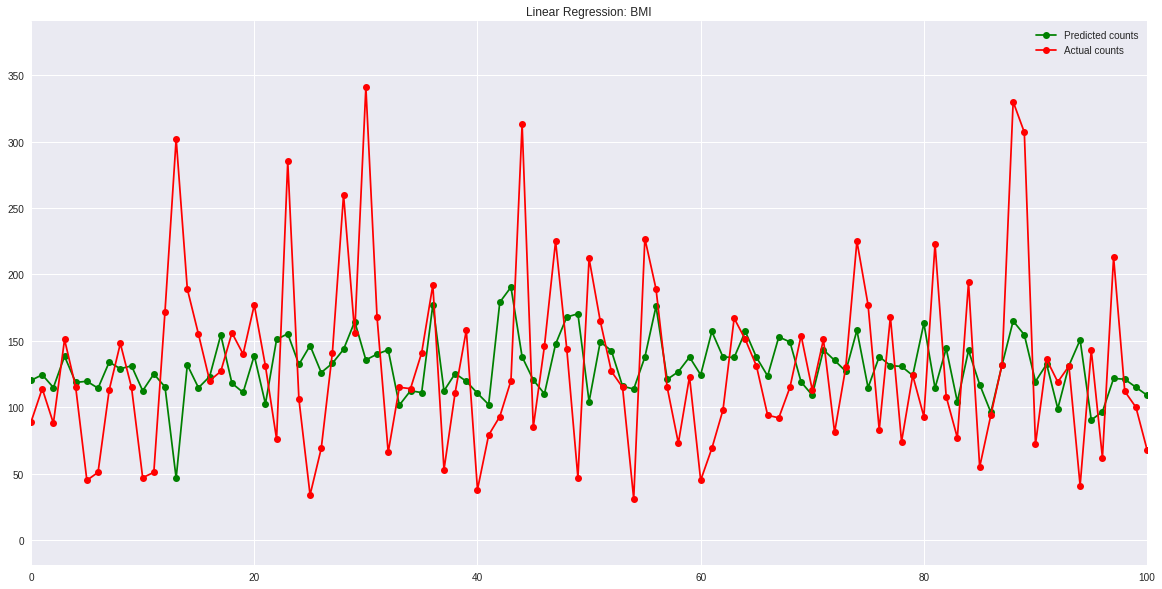

In [1039]:
fig = plt.figure()

plt.figure(figsize=(20,10))
plt.title('Linear Regression: BMI')
plt.xlim(0,100)
predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'go-', label='Predicted counts')
actual, = plt.plot(pd.DataFrame(y_test.flatten()), 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
 
plt.show()

In [1029]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 44.05903001417194
Mean Squared Error: 3317.9771715902816
Root Mean Squared Error: 57.601885139206004


#### Neural Network

In [1075]:
X_train, X_test , y_train , y_test = train_test_split(X_1, y_1, test_size=0.30, random_state=1)
dnn_model = Sequential()
dnn_model.add(Dense(32,input_shape=(X_1.shape[1],),activation='relu'))
dnn_model.add(Dense(16,activation='relu'))
dnn_model.add(Dense(4,activation='relu'))
dnn_model.add(Dense(1))
dnn_model.compile(Adam(lr=0.02),'mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss',patience=8,verbose=1)
dn_history = dnn_model.fit(X_train,y_train, verbose=2, epochs=90, validation_data=(X_test,y_test), batch_size=700,callbacks=[early_stop])

Train on 7445 samples, validate on 3192 samples
Epoch 1/90
 - 4s - loss: 8903.2145 - val_loss: 5196.2535
Epoch 2/90
 - 0s - loss: 4273.7984 - val_loss: 3882.0126
Epoch 3/90
 - 0s - loss: 3650.9166 - val_loss: 3489.5221
Epoch 4/90
 - 0s - loss: 3403.7877 - val_loss: 3407.4948
Epoch 5/90
 - 0s - loss: 3326.4304 - val_loss: 3369.0745
Epoch 6/90
 - 0s - loss: 3279.0818 - val_loss: 3458.8576
Epoch 7/90
 - 0s - loss: 3288.5858 - val_loss: 3374.3695
Epoch 8/90
 - 0s - loss: 3244.8429 - val_loss: 3347.0610
Epoch 9/90
 - 0s - loss: 3242.1064 - val_loss: 3417.0316
Epoch 10/90
 - 0s - loss: 3275.4304 - val_loss: 3337.0473
Epoch 11/90
 - 0s - loss: 3216.0443 - val_loss: 3293.0907
Epoch 12/90
 - 0s - loss: 3202.7104 - val_loss: 3307.7395
Epoch 13/90
 - 0s - loss: 3206.4180 - val_loss: 3323.5504
Epoch 14/90
 - 0s - loss: 3192.2464 - val_loss: 3374.1130
Epoch 15/90
 - 0s - loss: 3222.5829 - val_loss: 3335.2774
Epoch 16/90
 - 0s - loss: 3199.9137 - val_loss: 3344.0799
Epoch 17/90
 - 0s - loss: 3208.89

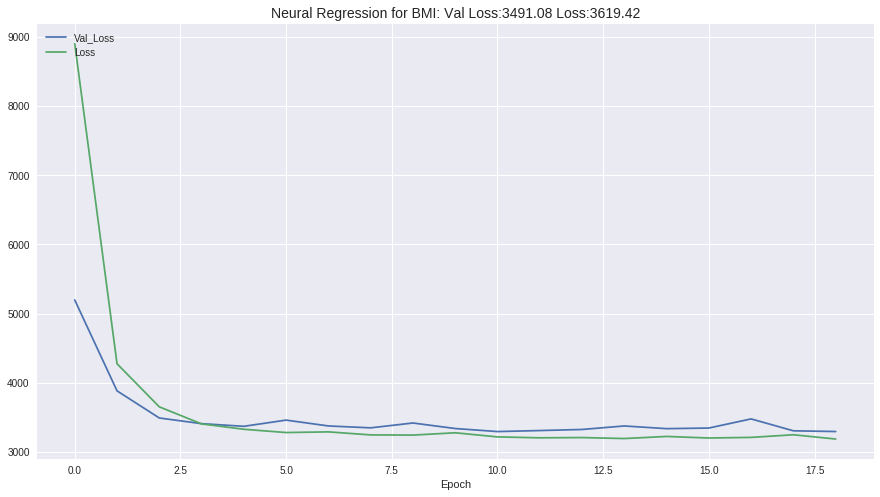

In [1076]:
plotTrainingHist(dn_history, 30, 'Neural Regression for BMI')

In [0]:
y_pred = dnn_model.predict(X_test)

<Figure size 432x288 with 0 Axes>

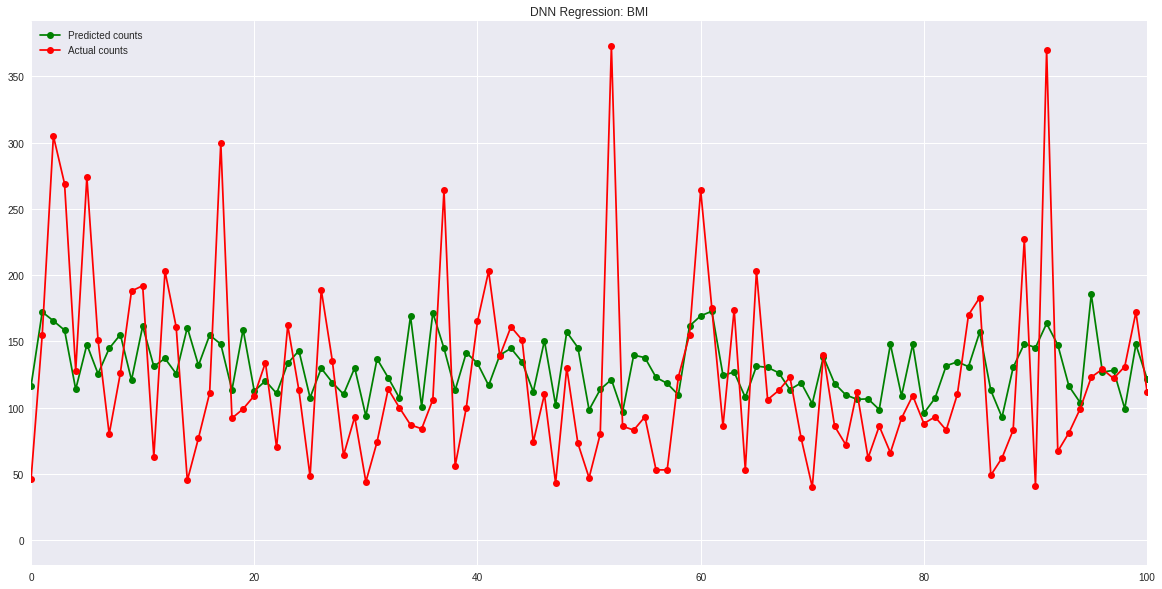

In [1078]:
fig = plt.figure()

plt.figure(figsize=(20,10))
plt.title('DNN Regression: BMI')
plt.xlim(0,100)
predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'go-', label='Predicted counts')
actual, = plt.plot(pd.DataFrame(y_test.flatten()), 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
 
plt.show()

In [1079]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 43.87275945811642
Mean Squared Error: 3293.7136837766475
Root Mean Squared Error: 57.39088502346559
